# Graph Neural Networks in Recommender Systems
## A Numerical Tutorial with NGCF and LightGCN

This notebook provides a comprehensive, hands-on demonstration of Graph Neural Networks (GNNs) applied to recommender systems. We will explore:

1. **Bipartite Graph Representation**: How user-item interactions form a graph
2. **High-Order Connectivity**: Capturing multi-hop relationships beyond direct interactions
3. **NGCF (Neural Graph Collaborative Filtering)**: Message passing with feature transformation
4. **LightGCN**: Simplified linear propagation that outperforms complex models

We use a concrete example with **7 users** and **8 items** to demonstrate these concepts numerically.

---
## Key Mathematical Concepts

### Graph Representation
- **Bipartite Graph**: $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ where $\mathcal{V} = \mathcal{U} \cup \mathcal{I}$
- **Adjacency Matrix**: $A \in \mathbb{R}^{(M+N) \times (M+N)}$
- **Normalized Laplacian**: $\tilde{A} = D^{-1/2} A D^{-1/2}$

### LightGCN Propagation
$$e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u||N_i|}} e_i^{(k)}$$

### Layer Combination
$$e_u = \sum_{k=0}^K \alpha_k e_u^{(k)} \quad \text{where } \alpha_k = \frac{1}{K+1}$$

## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.patches import FancyBboxPatch, ConnectionPatch
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 1.26.4


## 2. Create User-Item Interaction Matrix and Bipartite Graph

The interaction matrix $R \in \mathbb{R}^{M \times N}$ can be viewed as defining a **bipartite graph**:
- **User nodes**: $\mathcal{U} = \{U_1, U_2, ..., U_M\}$
- **Item nodes**: $\mathcal{I} = \{I_1, I_2, ..., I_N\}$
- **Edges**: An edge $(u, i) \in \mathcal{E}$ exists if user $u$ interacted with item $i$

We'll use the same 7 users × 8 items example from our Matrix Factorization tutorial.

In [2]:
# Define dimensions
M = 7  # Number of users
N = 8  # Number of items
users = [f'U{i+1}' for i in range(M)]
items = [f'I{i+1}' for i in range(N)]

# Create a sparse user-item interaction matrix R (binary: 1 = interacted, 0 = no interaction)
# Using the same pattern as MF tutorial but converted to binary
R = np.array([
    [1, 0, 1, 0, 0, 1, 0, 1],   # U1: interacted with I1, I3, I6, I8
    [0, 1, 0, 1, 0, 0, 1, 0],   # U2: interacted with I2, I4, I7
    [1, 0, 0, 1, 1, 0, 0, 0],   # U3: interacted with I1, I4, I5
    [0, 0, 1, 0, 1, 0, 0, 1],   # U4: interacted with I3, I5, I8
    [1, 1, 0, 0, 0, 1, 0, 0],   # U5: interacted with I1, I2, I6
    [0, 0, 0, 1, 0, 1, 1, 0],   # U6: interacted with I4, I6, I7
    [0, 1, 1, 0, 0, 0, 0, 1],   # U7: interacted with I2, I3, I8
], dtype=float)

# Calculate statistics
total_entries = M * N
num_interactions = int(np.sum(R))
sparsity = 1 - (num_interactions / total_entries)

print("=" * 70)
print("USER-ITEM INTERACTION MATRIX (Binary)")
print("=" * 70)
print(f"\nMatrix Shape: {M} users × {N} items = {total_entries} total entries")
print(f"Number of Interactions: {num_interactions} ({100*(1-sparsity):.1f}%)")
print(f"Sparsity: {100*sparsity:.1f}%")

print("\nInteraction Matrix R (1 = interaction, 0 = no interaction):")
print("-" * 70)
print("      ", end="")
for item in items:
    print(f"{item:>5}", end="")
print()
print("      " + "-" * 40)

for i, user in enumerate(users):
    print(f"{user:>5} |", end="")
    for j in range(N):
        if R[i, j] == 1:
            print(f"{'●':>5}", end="")
        else:
            print(f"{'·':>5}", end="")
    print()

print("\n" + "=" * 70)

USER-ITEM INTERACTION MATRIX (Binary)

Matrix Shape: 7 users × 8 items = 56 total entries
Number of Interactions: 22 (39.3%)
Sparsity: 60.7%

Interaction Matrix R (1 = interaction, 0 = no interaction):
----------------------------------------------------------------------
         I1   I2   I3   I4   I5   I6   I7   I8
      ----------------------------------------
   U1 |    ●    ·    ●    ·    ·    ●    ·    ●
   U2 |    ·    ●    ·    ●    ·    ·    ●    ·
   U3 |    ●    ·    ·    ●    ●    ·    ·    ·
   U4 |    ·    ·    ●    ·    ●    ·    ·    ●
   U5 |    ●    ●    ·    ·    ·    ●    ·    ·
   U6 |    ·    ·    ·    ●    ·    ●    ●    ·
   U7 |    ·    ●    ●    ·    ·    ·    ·    ●



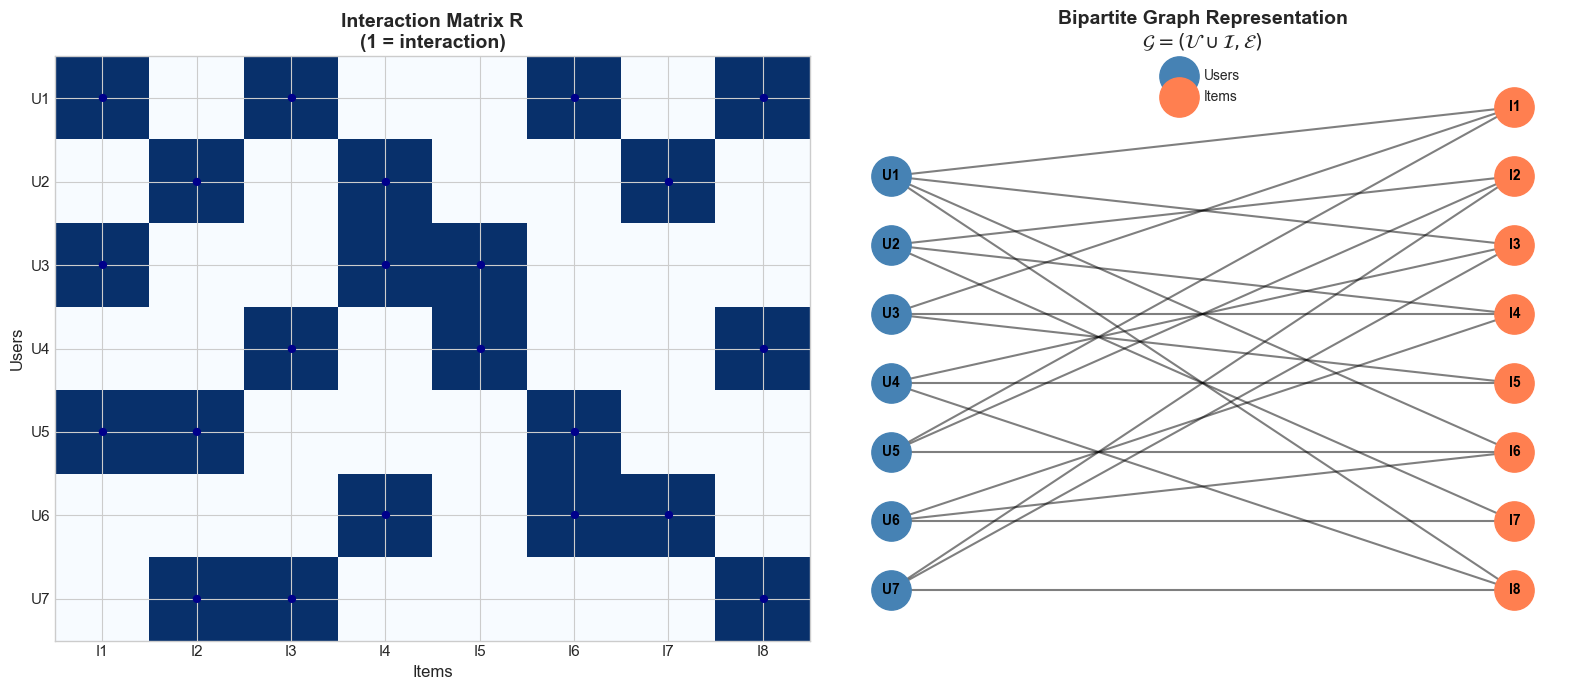


📊 Graph Statistics:
   • Total nodes: 15 (7 users + 8 items)
   • Total edges: 22 interactions


In [3]:
# Visualize the bipartite graph
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Interaction matrix heatmap
ax1 = axes[0]
im1 = ax1.imshow(R, cmap='Blues', aspect='auto', vmin=0, vmax=1)
ax1.set_xticks(range(N))
ax1.set_yticks(range(M))
ax1.set_xticklabels(items, fontsize=11)
ax1.set_yticklabels(users, fontsize=11)
ax1.set_title('Interaction Matrix R\n(1 = interaction)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Items', fontsize=12)
ax1.set_ylabel('Users', fontsize=12)

for i in range(M):
    for j in range(N):
        text = '●' if R[i, j] == 1 else ''
        ax1.text(j, i, text, ha='center', va='center', fontsize=14, color='darkblue')

# Right: Bipartite graph visualization
ax2 = axes[1]

# Create bipartite graph
G = nx.Graph()

# Add user nodes
for i, user in enumerate(users):
    G.add_node(user, bipartite=0, node_type='user')

# Add item nodes
for i, item in enumerate(items):
    G.add_node(item, bipartite=1, node_type='item')

# Add edges based on interactions
for i in range(M):
    for j in range(N):
        if R[i, j] == 1:
            G.add_edge(users[i], items[j])

# Position nodes in two columns
pos = {}
for i, user in enumerate(users):
    pos[user] = (0, M - 1 - i)
for i, item in enumerate(items):
    pos[item] = (2, N - 1 - i)

# Draw the graph
user_nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == 'user']
item_nodes = [n for n, d in G.nodes(data=True) if d['node_type'] == 'item']

nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='steelblue', 
                       node_size=800, ax=ax2, label='Users')
nx.draw_networkx_nodes(G, pos, nodelist=item_nodes, node_color='coral', 
                       node_size=800, ax=ax2, label='Items')
nx.draw_networkx_edges(G, pos, alpha=0.5, width=1.5, ax=ax2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax2)

ax2.set_title('Bipartite Graph Representation\n$\\mathcal{G} = (\\mathcal{U} \\cup \\mathcal{I}, \\mathcal{E})$', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='upper center', fontsize=10)
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"\n📊 Graph Statistics:")
print(f"   • Total nodes: {G.number_of_nodes()} (7 users + 8 items)")
print(f"   • Total edges: {G.number_of_edges()} interactions")

## 3. Construct the Graph Adjacency Matrix

For GNN-based recommender systems, we construct a combined adjacency matrix $A$ that includes both users and items:

$$A = \begin{pmatrix} 0 & R \\ R^T & 0 \end{pmatrix} \in \mathbb{R}^{(M+N) \times (M+N)}$$

This matrix represents the full bipartite graph where:
- The upper-right block $R$ captures user-to-item connections
- The lower-left block $R^T$ captures item-to-user connections
- The diagonal blocks are zero (no user-user or item-item direct edges)

In [5]:
# Construct the adjacency matrix A for the bipartite graph
# A = [[0, R], [R^T, 0]]

n_nodes = M + N  # Total number of nodes (users + items)

# Create adjacency matrix
A = np.zeros((n_nodes, n_nodes))
A[:M, M:] = R          # Upper right: user-to-item
A[M:, :M] = R.T        # Lower left: item-to-user

# Create node labels
node_labels = users + items

print("=" * 80)
print("ADJACENCY MATRIX CONSTRUCTION")
print("=" * 80)

print("\n📐 Matrix Structure:")
print(f"   A ∈ ℝ^({n_nodes} × {n_nodes}) = ℝ^(({M}+{N}) × ({M}+{N}))")
print("\n   A = | 0_MxM    R_MxN |")
print("       | R^T_NxM  0_NxN |")

print(f"\n📊 Adjacency Matrix A (showing structure):")
print("-" * 80)

# Print header
print("         ", end="")
for label in node_labels:
    print(f"{label:>4}", end="")
print()
print("         " + "-" * (4 * n_nodes))

# Print matrix with labels
for i, row_label in enumerate(node_labels):
    print(f"{row_label:>8} |", end="")
    for j in range(n_nodes):
        if A[i, j] == 1:
            print(f"{'1':>4}", end="")
        else:
            print(f"{'·':>4}", end="")
    print()

# Calculate degree matrix
degrees = np.sum(A, axis=1)
print("\n" + "=" * 80)
print("NODE DEGREES (Number of connections)")
print("=" * 80)
print("\nUser degrees (number of items interacted with):")
for i, user in enumerate(users):
    print(f"   {user}: degree = {int(degrees[i])}")

print("\nItem degrees (number of users who interacted):")
for i, item in enumerate(items):
    print(f"   {item}: degree = {int(degrees[M + i])}")

ADJACENCY MATRIX CONSTRUCTION

📐 Matrix Structure:
   A ∈ ℝ^(15 × 15) = ℝ^((7+8) × (7+8))

   A = | 0_MxM    R_MxN |
       | R^T_NxM  0_NxN |

📊 Adjacency Matrix A (showing structure):
--------------------------------------------------------------------------------
           U1  U2  U3  U4  U5  U6  U7  I1  I2  I3  I4  I5  I6  I7  I8
         ------------------------------------------------------------
      U1 |   ·   ·   ·   ·   ·   ·   ·   1   ·   1   ·   ·   1   ·   1
      U2 |   ·   ·   ·   ·   ·   ·   ·   ·   1   ·   1   ·   ·   1   ·
      U3 |   ·   ·   ·   ·   ·   ·   ·   1   ·   ·   1   1   ·   ·   ·
      U4 |   ·   ·   ·   ·   ·   ·   ·   ·   ·   1   ·   1   ·   ·   1
      U5 |   ·   ·   ·   ·   ·   ·   ·   1   1   ·   ·   ·   1   ·   ·
      U6 |   ·   ·   ·   ·   ·   ·   ·   ·   ·   ·   1   ·   1   1   ·
      U7 |   ·   ·   ·   ·   ·   ·   ·   ·   1   1   ·   ·   ·   ·   1
      I1 |   1   ·   1   ·   1   ·   ·   ·   ·   ·   ·   ·   ·   ·   ·
      I2 |   ·   1   ·   

## 4. High-Order Connectivity: Understanding Multi-Hop Paths

The key insight of GNN-based recommenders is capturing **high-order connectivity**:
- **1st-order**: Direct user-item interactions (what MF captures)
- **2nd-order**: User-item-user paths → users with shared interests
- **3rd-order**: User-item-user-item paths → items preferred by similar users

For example: $U_1 \rightarrow I_1 \rightarrow U_3 \rightarrow I_5$ means:
- U1 bought I1
- U3 also bought I1 (so U1 and U3 have similar tastes)
- U3 also bought I5
- Therefore, U1 might be interested in I5!

Let's explore these paths numerically.

In [6]:
# Analyze high-order connectivity
print("=" * 80)
print("HIGH-ORDER CONNECTIVITY ANALYSIS")
print("=" * 80)

# 1st-order: Direct neighbors (A^1)
A1 = A.copy()

# 2nd-order: 2-hop paths (A^2)
A2 = A @ A

# 3rd-order: 3-hop paths (A^3)  
A3 = A @ A @ A

print("\n📍 1st-Order (Direct Connections):")
print("-" * 80)
print("A^1 captures direct user-item interactions")
print("\nExample: U1's direct neighbors (items U1 interacted with):")
u1_neighbors = np.where(A[0] > 0)[0]
neighbor_names = [node_labels[i] for i in u1_neighbors]
print(f"   U1 → {neighbor_names}")

print("\n📍 2nd-Order (2-hop Paths):")
print("-" * 80)
print("A^2 captures: User-Item-User (co-purchased) and Item-User-Item (co-purchased by)")
print("\nExample: A²[U1, U3] = number of 2-hop paths from U1 to U3")
print(f"   A²[U1, U3] = {int(A2[0, 2])}")
print("   This means U1 and U3 share 1 item in common (I1)")

# Find shared items between U1 and U3
u1_items = set(np.where(R[0] > 0)[0])
u3_items = set(np.where(R[2] > 0)[0])
shared_items = u1_items & u3_items
print(f"   Verification: U1's items = {[items[i] for i in u1_items]}")
print(f"                 U3's items = {[items[i] for i in u3_items]}")
print(f"                 Shared items = {[items[i] for i in shared_items]}")

print("\n📍 3rd-Order (3-hop Paths):")
print("-" * 80)
print("A^3 captures: User-Item-User-Item (collaborative filtering signal)")
print("\nExample: A³[U1, I5] = number of 3-hop paths from U1 to I5")
print(f"   A³[U1, I5] = {int(A3[0, M + 4])}")
print("   These paths represent items that similar users liked!")

# Trace the paths
print("\n   Tracing paths U1 → ? → ? → I5:")
count = 0
for item_idx in range(N):
    if R[0, item_idx] == 1:  # U1 interacted with this item
        for other_user in range(M):
            if other_user != 0 and R[other_user, item_idx] == 1:  # Another user also interacted
                if R[other_user, 4] == 1:  # That user interacted with I5
                    count += 1
                    if count <= 3:  # Show first 3 paths
                        print(f"      Path {count}: U1 → {items[item_idx]} → {users[other_user]} → I5")

print(f"\n   Total 3-hop paths from U1 to I5: {count}")
print("\n" + "=" * 80)

HIGH-ORDER CONNECTIVITY ANALYSIS

📍 1st-Order (Direct Connections):
--------------------------------------------------------------------------------
A^1 captures direct user-item interactions

Example: U1's direct neighbors (items U1 interacted with):
   U1 → ['I1', 'I3', 'I6', 'I8']

📍 2nd-Order (2-hop Paths):
--------------------------------------------------------------------------------
A^2 captures: User-Item-User (co-purchased) and Item-User-Item (co-purchased by)

Example: A²[U1, U3] = number of 2-hop paths from U1 to U3
   A²[U1, U3] = 1
   This means U1 and U3 share 1 item in common (I1)
   Verification: U1's items = ['I1', 'I3', 'I6', 'I8']
                 U3's items = ['I1', 'I4', 'I5']
                 Shared items = ['I1']

📍 3rd-Order (3-hop Paths):
--------------------------------------------------------------------------------
A^3 captures: User-Item-User-Item (collaborative filtering signal)

Example: A³[U1, I5] = number of 3-hop paths from U1 to I5
   A³[U1, I5] = 3


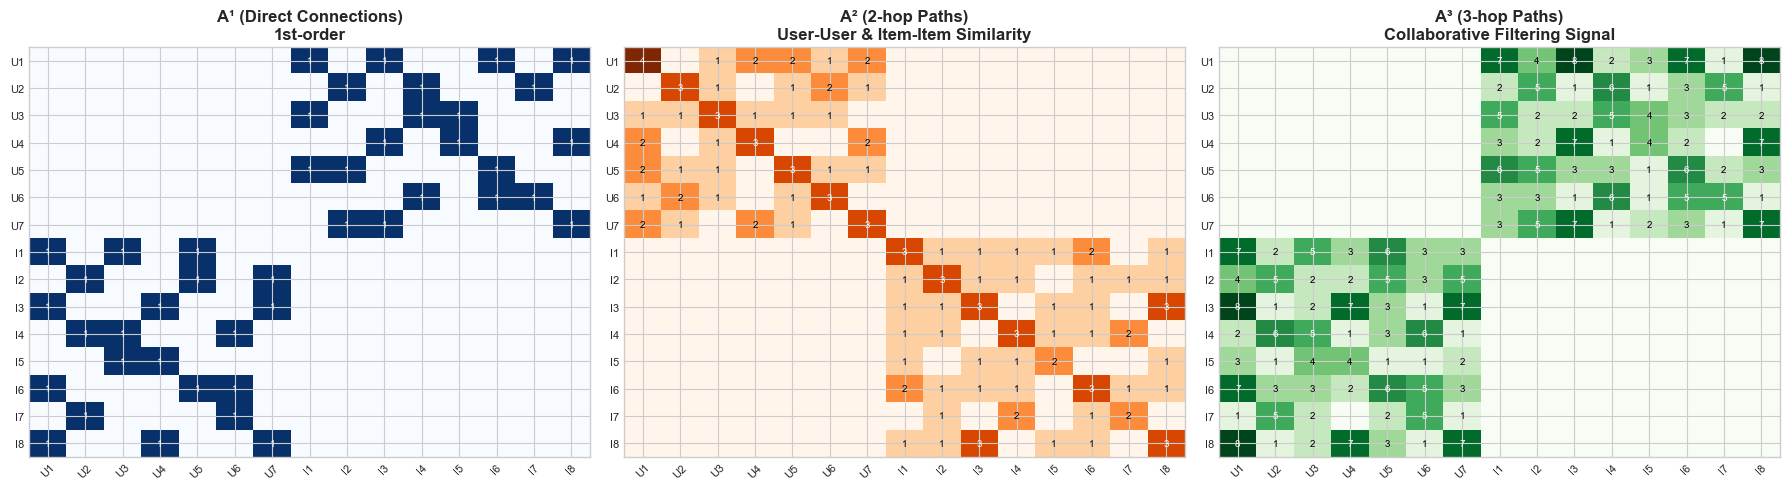


💡 Key Insight:
   • A² diagonal for users shows how many items each user interacted with
   • A² off-diagonal for users shows how many items two users have in common
   • A³ shows the collaborative filtering signal (items that similar users liked)


In [7]:
# Visualize high-order connectivity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Helper function to show matrix
def show_matrix(ax, matrix, title, labels, cmap='Blues'):
    im = ax.imshow(matrix, cmap=cmap, aspect='auto')
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=8, rotation=45)
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    # Add text annotations for non-zero values
    for i in range(len(labels)):
        for j in range(len(labels)):
            if matrix[i, j] > 0:
                text_color = 'white' if matrix[i, j] > matrix.max()/2 else 'black'
                ax.text(j, i, f'{int(matrix[i, j])}', ha='center', va='center', 
                       fontsize=7, color=text_color)
    return im

# A^1: Direct connections
show_matrix(axes[0], A, 'A¹ (Direct Connections)\n1st-order', node_labels)

# A^2: 2-hop paths (user-user and item-item similarity)
show_matrix(axes[1], A2, 'A² (2-hop Paths)\nUser-User & Item-Item Similarity', node_labels, 'Oranges')

# A^3: 3-hop paths (collaborative filtering signal)
show_matrix(axes[2], A3, 'A³ (3-hop Paths)\nCollaborative Filtering Signal', node_labels, 'Greens')

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("   • A² diagonal for users shows how many items each user interacted with")
print("   • A² off-diagonal for users shows how many items two users have in common")
print("   • A³ shows the collaborative filtering signal (items that similar users liked)")

## 5. NGCF: Neural Graph Collaborative Filtering

NGCF (He et al., 2019) was one of the first architectures to explicitly encode collaborative signals using GNNs.

### NGCF Propagation Rule
For user $u$ at layer $l+1$:
$$e_u^{(l+1)} = \sigma \left( W_1 e_u^{(l)} + \sum_{i \in N_u} \frac{1}{\sqrt{|N_u||N_i|}} \left(W_1 e_i^{(l)} + W_2 (e_i^{(l)} \odot e_u^{(l)})\right) \right)$$

Components:
1. **Self-connection**: $W_1 e_u^{(l)}$ - retains user's own information
2. **Neighbor aggregation**: $W_1 e_i^{(l)}$ - aggregates neighbor features
3. **Feature interaction**: $W_2 (e_i^{(l)} \odot e_u^{(l)})$ - element-wise product to capture affinity
4. **Non-linearity**: $\sigma$ (LeakyReLU)

Let's implement this with K=4 latent dimensions.

In [8]:
# NGCF Implementation
K = 4  # Embedding dimension

def leaky_relu(x, alpha=0.2):
    """LeakyReLU activation function"""
    return np.where(x > 0, x, alpha * x)

class NGCF:
    def __init__(self, n_users, n_items, embed_dim, n_layers=2):
        self.n_users = n_users
        self.n_items = n_items
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        
        # Initialize embeddings (layer 0)
        np.random.seed(42)
        self.E0 = np.random.randn(n_users + n_items, embed_dim) * 0.1
        
        # Initialize weight matrices for each layer
        self.W1 = [np.random.randn(embed_dim, embed_dim) * 0.1 for _ in range(n_layers)]
        self.W2 = [np.random.randn(embed_dim, embed_dim) * 0.1 for _ in range(n_layers)]
        
    def propagate_layer(self, E, A_norm, layer_idx):
        """NGCF propagation for one layer"""
        n = E.shape[0]
        E_new = np.zeros_like(E)
        
        W1 = self.W1[layer_idx]
        W2 = self.W2[layer_idx]
        
        for i in range(n):
            # Self-connection
            self_term = E[i] @ W1
            
            # Neighbor aggregation
            neighbors = np.where(A_norm[i] > 0)[0]
            agg_term = np.zeros(self.embed_dim)
            
            for j in neighbors:
                norm_factor = A_norm[i, j]
                # Standard neighbor term
                neighbor_term = E[j] @ W1
                # Interaction term (element-wise product)
                interaction_term = (E[j] * E[i]) @ W2
                agg_term += norm_factor * (neighbor_term + interaction_term)
            
            # Combine and apply activation
            E_new[i] = leaky_relu(self_term + agg_term)
        
        return E_new
    
    def forward(self, A_norm):
        """Forward pass through all layers"""
        E_layers = [self.E0.copy()]
        E = self.E0.copy()
        
        for l in range(self.n_layers):
            E = self.propagate_layer(E, A_norm, l)
            E_layers.append(E.copy())
        
        # Concatenate all layer embeddings (NGCF uses concatenation)
        E_final = np.concatenate(E_layers, axis=1)
        return E_final, E_layers

# Compute normalized adjacency matrix
degrees = np.sum(A, axis=1)
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(degrees, 1)))
A_norm = D_inv_sqrt @ A @ D_inv_sqrt

# Initialize and run NGCF
ngcf = NGCF(M, N, K, n_layers=2)

print("=" * 80)
print("NGCF: NEURAL GRAPH COLLABORATIVE FILTERING")
print("=" * 80)

print(f"\n⚙️ Model Configuration:")
print(f"   • Users: {M}, Items: {N}")
print(f"   • Embedding dimension: {K}")
print(f"   • Number of layers: 2")

print(f"\n📐 Initial Embeddings E^(0) ∈ ℝ^({M+N} × {K}):")
print("-" * 80)
print("        Dim1      Dim2      Dim3      Dim4")
print("        " + "-" * 40)
for i, label in enumerate(node_labels):
    print(f"{label:>5}  [{ngcf.E0[i,0]:+7.4f}, {ngcf.E0[i,1]:+7.4f}, {ngcf.E0[i,2]:+7.4f}, {ngcf.E0[i,3]:+7.4f}]")

NGCF: NEURAL GRAPH COLLABORATIVE FILTERING

⚙️ Model Configuration:
   • Users: 7, Items: 8
   • Embedding dimension: 4
   • Number of layers: 2

📐 Initial Embeddings E^(0) ∈ ℝ^(15 × 4):
--------------------------------------------------------------------------------
        Dim1      Dim2      Dim3      Dim4
        ----------------------------------------
   U1  [+0.0497, -0.0138, +0.0648, +0.1523]
   U2  [-0.0234, -0.0234, +0.1579, +0.0767]
   U3  [-0.0469, +0.0543, -0.0463, -0.0466]
   U4  [+0.0242, -0.1913, -0.1725, -0.0562]
   U5  [-0.1013, +0.0314, -0.0908, -0.1412]
   U6  [+0.1466, -0.0226, +0.0068, -0.1425]
   U7  [-0.0544, +0.0111, -0.1151, +0.0376]
   I1  [-0.0601, -0.0292, -0.0602, +0.1852]
   I2  [-0.0013, -0.1058, +0.0823, -0.1221]
   I3  [+0.0209, -0.1960, -0.1328, +0.0197]
   I4  [+0.0738, +0.0171, -0.0116, -0.0301]
   I5  [-0.1479, -0.0720, -0.0461, +0.1057]
   I6  [+0.0344, -0.1763, +0.0324, -0.0385]
   I7  [-0.0677, +0.0612, +0.1031, +0.0931]
   I8  [-0.0839, -0.0309

In [9]:
# Demonstrate NGCF propagation step by step for U1
print("=" * 80)
print("NGCF PROPAGATION EXAMPLE: Computing e_U1^(1)")
print("=" * 80)

u1_idx = 0
u1_neighbors = np.where(A[u1_idx] > 0)[0]
neighbor_names = [node_labels[i] for i in u1_neighbors]

print(f"\n📍 U1's neighbors: {neighbor_names}")
print(f"   Neighbor indices: {list(u1_neighbors)}")

print(f"\n🔢 Step-by-step computation:")
print("-" * 80)

# Get U1's embedding
e_u1 = ngcf.E0[u1_idx]
print(f"\n1. Self-connection term:")
print(f"   e_U1^(0) = [{e_u1[0]:+.4f}, {e_u1[1]:+.4f}, {e_u1[2]:+.4f}, {e_u1[3]:+.4f}]")
self_term = e_u1 @ ngcf.W1[0]
print(f"   W1 @ e_U1^(0) = [{self_term[0]:+.4f}, {self_term[1]:+.4f}, {self_term[2]:+.4f}, {self_term[3]:+.4f}]")

print(f"\n2. Neighbor aggregation term:")
agg_term = np.zeros(K)
for j in u1_neighbors:
    e_j = ngcf.E0[j]
    norm_factor = A_norm[u1_idx, j]
    neighbor_term = e_j @ ngcf.W1[0]
    interaction_term = (e_j * e_u1) @ ngcf.W2[0]
    contribution = norm_factor * (neighbor_term + interaction_term)
    agg_term += contribution
    
    print(f"\n   Neighbor {node_labels[j]}:")
    print(f"      e_{node_labels[j]} = [{e_j[0]:+.4f}, {e_j[1]:+.4f}, {e_j[2]:+.4f}, {e_j[3]:+.4f}]")
    print(f"      Normalization: 1/√(|N_U1|·|N_{node_labels[j]}|) = {norm_factor:.4f}")
    print(f"      Contribution = [{contribution[0]:+.4f}, {contribution[1]:+.4f}, {contribution[2]:+.4f}, {contribution[3]:+.4f}]")

print(f"\n   Aggregated term = [{agg_term[0]:+.4f}, {agg_term[1]:+.4f}, {agg_term[2]:+.4f}, {agg_term[3]:+.4f}]")

print(f"\n3. Combine and apply LeakyReLU:")
combined = self_term + agg_term
print(f"   Before activation = [{combined[0]:+.4f}, {combined[1]:+.4f}, {combined[2]:+.4f}, {combined[3]:+.4f}]")
e_u1_new = leaky_relu(combined)
print(f"   e_U1^(1) = LeakyReLU(·) = [{e_u1_new[0]:+.4f}, {e_u1_new[1]:+.4f}, {e_u1_new[2]:+.4f}, {e_u1_new[3]:+.4f}]")

# Run full forward pass
E_final_ngcf, E_layers_ngcf = ngcf.forward(A_norm)

print("\n" + "=" * 80)
print("NGCF Layer-wise Embeddings for U1")
print("=" * 80)
for l, E_l in enumerate(E_layers_ngcf):
    e = E_l[0]
    print(f"   Layer {l}: [{e[0]:+.4f}, {e[1]:+.4f}, {e[2]:+.4f}, {e[3]:+.4f}]")

print(f"\n   Final (concatenated): {E_final_ngcf.shape[1]} dimensions")
print("=" * 80)

NGCF PROPAGATION EXAMPLE: Computing e_U1^(1)

📍 U1's neighbors: ['I1', 'I3', 'I6', 'I8']
   Neighbor indices: [7, 9, 12, 14]

🔢 Step-by-step computation:
--------------------------------------------------------------------------------

1. Self-connection term:
   e_U1^(0) = [+0.0497, -0.0138, +0.0648, +0.1523]
   W1 @ e_U1^(0) = [-0.0017, +0.0169, -0.0430, +0.0152]

2. Neighbor aggregation term:

   Neighbor I1:
      e_I1 = [-0.0601, -0.0292, -0.0602, +0.1852]
      Normalization: 1/√(|N_U1|·|N_I1|) = 0.2887
      Contribution = [-0.0006, +0.0091, -0.0110, +0.0033]

   Neighbor I3:
      e_I3 = [+0.0209, -0.1960, -0.1328, +0.0197]
      Normalization: 1/√(|N_U1|·|N_I3|) = 0.2887
      Contribution = [-0.0060, -0.0043, -0.0029, -0.0117]

   Neighbor I6:
      e_I6 = [+0.0344, -0.1763, +0.0324, -0.0385]
      Normalization: 1/√(|N_U1|·|N_I6|) = 0.2887
      Contribution = [-0.0043, -0.0095, +0.0022, -0.0059]

   Neighbor I8:
      e_I8 = [-0.0839, -0.0309, +0.0331, +0.0976]
      Normal

## 6. LightGCN: Simplified but Powerful

**Key Insight**: He et al. (2020) showed that for collaborative filtering, the feature transformations ($W_1$, $W_2$) and non-linear activations are **not only unnecessary but harmful**.

### LightGCN's Simplification
LightGCN removes:
- ❌ Weight matrices $W_1$, $W_2$
- ❌ Non-linear activation $\sigma$
- ❌ Self-connection

What remains is pure **linear diffusion**:
$$e_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u||N_i|}} e_i^{(k)}$$

### Layer Combination
Instead of concatenating, LightGCN takes a weighted average:
$$e_u = \sum_{k=0}^K \alpha_k e_u^{(k)} \quad \text{where } \alpha_k = \frac{1}{K+1}$$

This multi-scale aggregation captures information at different distances:
- Layer 0: Node's own ID preference
- Layer 1: Direct interactions
- Layer 2: User-user similarity (shared items)
- Layer 3: Item-item similarity

In [10]:
# LightGCN Implementation
class LightGCN:
    def __init__(self, n_users, n_items, embed_dim, n_layers=3):
        self.n_users = n_users
        self.n_items = n_items
        self.embed_dim = embed_dim
        self.n_layers = n_layers
        
        # Initialize embeddings (layer 0) - these are the ONLY learnable parameters
        np.random.seed(42)
        self.E0 = np.random.randn(n_users + n_items, embed_dim) * 0.1
        
    def propagate_layer(self, E, A_norm):
        """LightGCN propagation: simple linear diffusion E^(k+1) = A_norm @ E^(k)"""
        return A_norm @ E
    
    def forward(self, A_norm):
        """Forward pass through all layers with layer combination"""
        E_layers = [self.E0.copy()]
        E = self.E0.copy()
        
        for l in range(self.n_layers):
            E = self.propagate_layer(E, A_norm)
            E_layers.append(E.copy())
        
        # Layer combination: average all layers (α_k = 1/(K+1))
        E_final = np.mean(E_layers, axis=0)
        return E_final, E_layers
    
    def predict(self, E_final, user_idx, item_idx):
        """Predict score as inner product"""
        e_user = E_final[user_idx]
        e_item = E_final[self.n_users + item_idx]
        return np.dot(e_user, e_item)

# Initialize LightGCN
lightgcn = LightGCN(M, N, K, n_layers=3)

print("=" * 80)
print("LightGCN: LIGHT GRAPH CONVOLUTIONAL NETWORK")
print("=" * 80)

print(f"\n⚙️ Model Configuration:")
print(f"   • Users: {M}, Items: {N}")
print(f"   • Embedding dimension: {K}")
print(f"   • Number of layers: 3")
print(f"   • Layer weights α_k = 1/(K+1) = 1/4 = 0.25")
print(f"   • Learnable parameters: ONLY E^(0) ({(M+N)*K} values)")

print(f"\n📐 Initial Embeddings E^(0) ∈ ℝ^({M+N} × {K}):")
print("-" * 80)
print("        Dim1      Dim2      Dim3      Dim4")
print("        " + "-" * 40)
for i, label in enumerate(node_labels):
    e = lightgcn.E0[i]
    print(f"{label:>5}  [{e[0]:+7.4f}, {e[1]:+7.4f}, {e[2]:+7.4f}, {e[3]:+7.4f}]")

LightGCN: LIGHT GRAPH CONVOLUTIONAL NETWORK

⚙️ Model Configuration:
   • Users: 7, Items: 8
   • Embedding dimension: 4
   • Number of layers: 3
   • Layer weights α_k = 1/(K+1) = 1/4 = 0.25
   • Learnable parameters: ONLY E^(0) (60 values)

📐 Initial Embeddings E^(0) ∈ ℝ^(15 × 4):
--------------------------------------------------------------------------------
        Dim1      Dim2      Dim3      Dim4
        ----------------------------------------
   U1  [+0.0497, -0.0138, +0.0648, +0.1523]
   U2  [-0.0234, -0.0234, +0.1579, +0.0767]
   U3  [-0.0469, +0.0543, -0.0463, -0.0466]
   U4  [+0.0242, -0.1913, -0.1725, -0.0562]
   U5  [-0.1013, +0.0314, -0.0908, -0.1412]
   U6  [+0.1466, -0.0226, +0.0068, -0.1425]
   U7  [-0.0544, +0.0111, -0.1151, +0.0376]
   I1  [-0.0601, -0.0292, -0.0602, +0.1852]
   I2  [-0.0013, -0.1058, +0.0823, -0.1221]
   I3  [+0.0209, -0.1960, -0.1328, +0.0197]
   I4  [+0.0738, +0.0171, -0.0116, -0.0301]
   I5  [-0.1479, -0.0720, -0.0461, +0.1057]
   I6  [+0.0344

In [11]:
# Demonstrate LightGCN propagation step by step for U1
print("=" * 80)
print("LightGCN PROPAGATION EXAMPLE: Computing e_U1 through all layers")
print("=" * 80)

u1_idx = 0
u1_neighbors = np.where(A[u1_idx] > 0)[0]
neighbor_names = [node_labels[i] for i in u1_neighbors]

print(f"\n📍 U1's neighbors: {neighbor_names}")

print(f"\n🔢 Layer-by-layer computation:")
print("-" * 80)

# Layer 0 (initial)
e_u1_0 = lightgcn.E0[u1_idx]
print(f"\nLayer 0 (Initial Embedding):")
print(f"   e_U1^(0) = [{e_u1_0[0]:+.4f}, {e_u1_0[1]:+.4f}, {e_u1_0[2]:+.4f}, {e_u1_0[3]:+.4f}]")

# Layer 1: Aggregate from direct neighbors (items)
print(f"\nLayer 1 (Aggregate from neighbor items):")
print(f"   e_U1^(1) = Σ_{'{i ∈ N_U1}'} (1/√|N_U1|·|N_i|) · e_i^(0)")
e_u1_1 = np.zeros(K)
for j in u1_neighbors:
    e_j = lightgcn.E0[j]
    norm_factor = A_norm[u1_idx, j]
    contribution = norm_factor * e_j
    e_u1_1 += contribution
    print(f"      + (1/√{int(degrees[u1_idx])}·{int(degrees[j])}) × e_{node_labels[j]} = {norm_factor:.4f} × [{e_j[0]:+.4f}, ...]")

print(f"   e_U1^(1) = [{e_u1_1[0]:+.4f}, {e_u1_1[1]:+.4f}, {e_u1_1[2]:+.4f}, {e_u1_1[3]:+.4f}]")

# Run full forward pass
E_final_lgcn, E_layers_lgcn = lightgcn.forward(A_norm)

print(f"\nLayer 2 (Aggregate from users who share items with U1):")
e_u1_2 = E_layers_lgcn[2][u1_idx]
print(f"   e_U1^(2) = Aggregates from users connected via shared items")
print(f"   e_U1^(2) = [{e_u1_2[0]:+.4f}, {e_u1_2[1]:+.4f}, {e_u1_2[2]:+.4f}, {e_u1_2[3]:+.4f}]")

print(f"\nLayer 3 (Aggregate from items preferred by similar users):")
e_u1_3 = E_layers_lgcn[3][u1_idx]
print(f"   e_U1^(3) = Collaborative filtering signal from 3-hop paths")
print(f"   e_U1^(3) = [{e_u1_3[0]:+.4f}, {e_u1_3[1]:+.4f}, {e_u1_3[2]:+.4f}, {e_u1_3[3]:+.4f}]")

print("\n" + "=" * 80)
print("LAYER COMBINATION")
print("=" * 80)
print(f"\ne_U1 = (1/4) × (e_U1^(0) + e_U1^(1) + e_U1^(2) + e_U1^(3))")
print(f"\n   Layer 0: [{e_u1_0[0]:+.4f}, {e_u1_0[1]:+.4f}, {e_u1_0[2]:+.4f}, {e_u1_0[3]:+.4f}]  (own preference)")
print(f"   Layer 1: [{e_u1_1[0]:+.4f}, {e_u1_1[1]:+.4f}, {e_u1_1[2]:+.4f}, {e_u1_1[3]:+.4f}]  (direct items)")
print(f"   Layer 2: [{e_u1_2[0]:+.4f}, {e_u1_2[1]:+.4f}, {e_u1_2[2]:+.4f}, {e_u1_2[3]:+.4f}]  (similar users)")
print(f"   Layer 3: [{e_u1_3[0]:+.4f}, {e_u1_3[1]:+.4f}, {e_u1_3[2]:+.4f}, {e_u1_3[3]:+.4f}]  (CF signal)")

e_u1_final = E_final_lgcn[u1_idx]
print(f"\n   Final e_U1 = [{e_u1_final[0]:+.4f}, {e_u1_final[1]:+.4f}, {e_u1_final[2]:+.4f}, {e_u1_final[3]:+.4f}]")
print("=" * 80)

LightGCN PROPAGATION EXAMPLE: Computing e_U1 through all layers

📍 U1's neighbors: ['I1', 'I3', 'I6', 'I8']

🔢 Layer-by-layer computation:
--------------------------------------------------------------------------------

Layer 0 (Initial Embedding):
   e_U1^(0) = [+0.0497, -0.0138, +0.0648, +0.1523]

Layer 1 (Aggregate from neighbor items):
   e_U1^(1) = Σ_{i ∈ N_U1} (1/√|N_U1|·|N_i|) · e_i^(0)
      + (1/√4·3) × e_I1 = 0.2887 × [-0.0601, ...]
      + (1/√4·3) × e_I3 = 0.2887 × [+0.0209, ...]
      + (1/√4·3) × e_I6 = 0.2887 × [+0.0344, ...]
      + (1/√4·3) × e_I8 = 0.2887 × [-0.0839, ...]
   e_U1^(1) = [-0.0256, -0.1248, -0.0368, +0.0762]

Layer 2 (Aggregate from users who share items with U1):
   e_U1^(2) = Aggregates from users connected via shared items
   e_U1^(2) = [+0.0008, -0.0302, -0.0550, +0.0018]

Layer 3 (Aggregate from items preferred by similar users):
   e_U1^(3) = Collaborative filtering signal from 3-hop paths
   e_U1^(3) = [-0.0346, -0.1090, -0.0193, +0.0531]

LAYER 

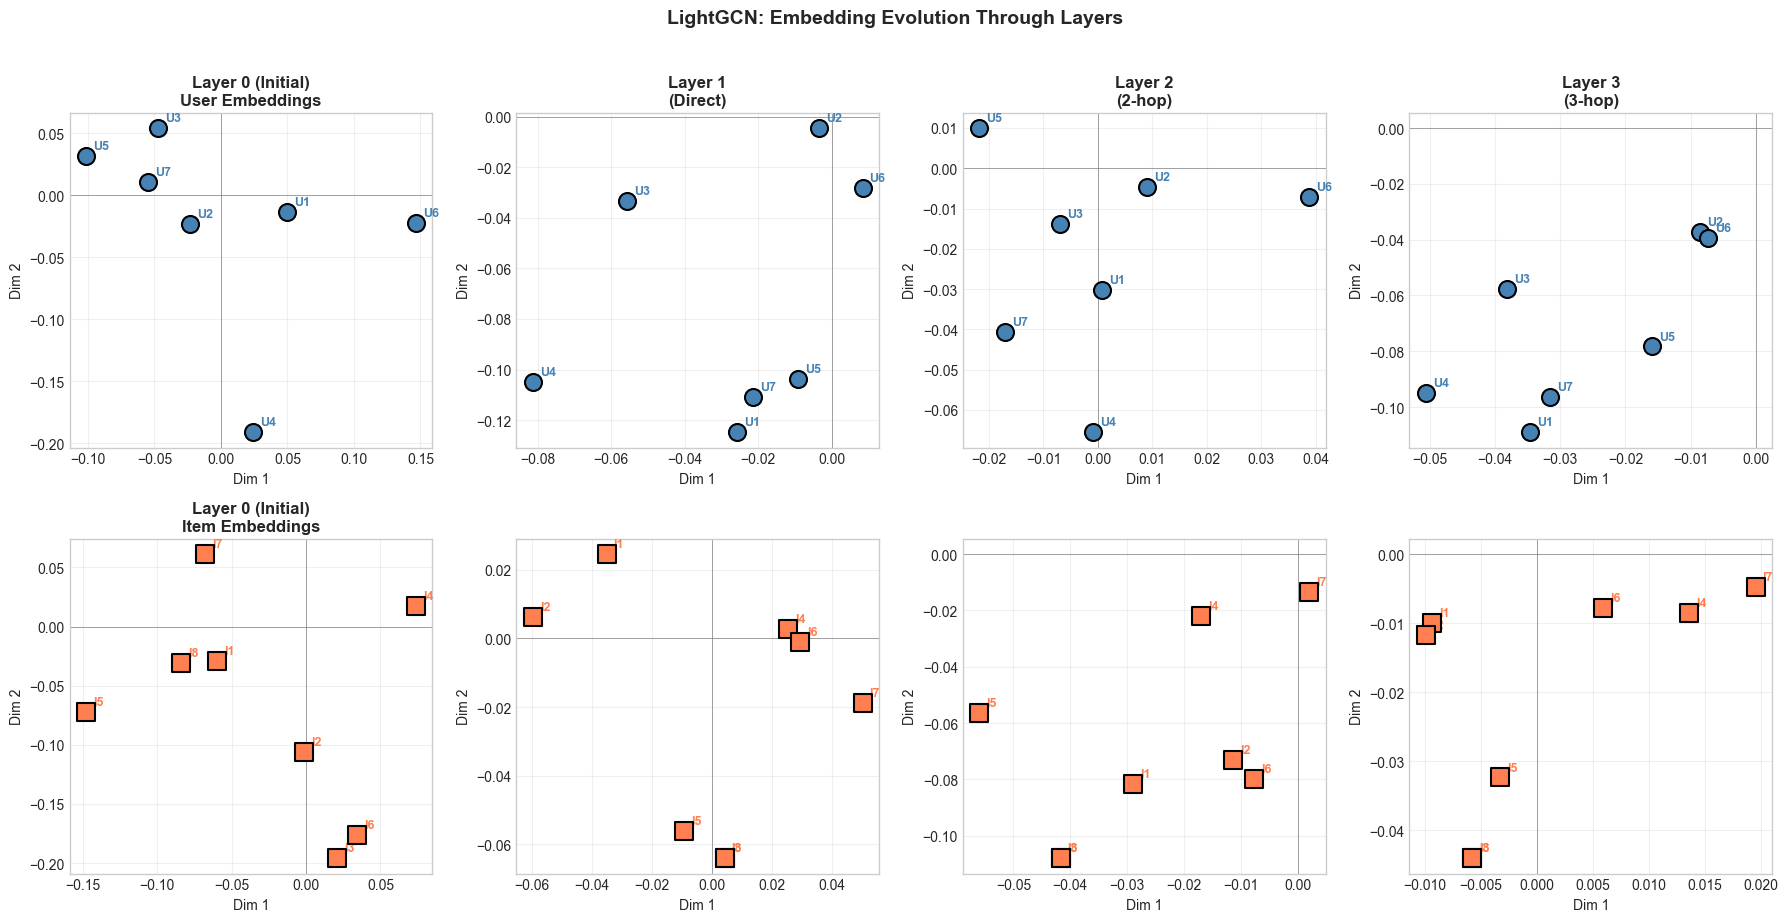


💡 Observation: As layers increase, embeddings of connected nodes become more similar
   This is the 'smoothing' effect of graph convolution!


In [12]:
# Visualize LightGCN embeddings at each layer
fig, axes = plt.subplots(2, 4, figsize=(18, 9))

layer_names = ['Layer 0\n(Initial)', 'Layer 1\n(Direct)', 'Layer 2\n(2-hop)', 'Layer 3\n(3-hop)']

# Top row: User embeddings at each layer
for l, (ax, E_l) in enumerate(zip(axes[0], E_layers_lgcn)):
    user_embeds = E_l[:M, :2]  # First 2 dimensions for visualization
    
    for i, user in enumerate(users):
        ax.scatter(user_embeds[i, 0], user_embeds[i, 1], c='steelblue', s=150, 
                  edgecolor='black', linewidth=1.5, zorder=5)
        ax.annotate(user, (user_embeds[i, 0], user_embeds[i, 1]), xytext=(5, 5),
                   textcoords='offset points', fontsize=9, fontweight='bold', color='steelblue')
    
    ax.set_title(f'{layer_names[l]}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Dim 1', fontsize=10)
    ax.set_ylabel('Dim 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

axes[0, 0].set_title('Layer 0 (Initial)\nUser Embeddings', fontsize=12, fontweight='bold')

# Bottom row: Item embeddings at each layer
for l, (ax, E_l) in enumerate(zip(axes[1], E_layers_lgcn)):
    item_embeds = E_l[M:, :2]  # First 2 dimensions for visualization
    
    for i, item in enumerate(items):
        ax.scatter(item_embeds[i, 0], item_embeds[i, 1], c='coral', s=150, 
                  edgecolor='black', linewidth=1.5, zorder=5, marker='s')
        ax.annotate(item, (item_embeds[i, 0], item_embeds[i, 1]), xytext=(5, 5),
                   textcoords='offset points', fontsize=9, fontweight='bold', color='coral')
    
    ax.set_xlabel('Dim 1', fontsize=10)
    ax.set_ylabel('Dim 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

axes[1, 0].set_title('Layer 0 (Initial)\nItem Embeddings', fontsize=12, fontweight='bold')

plt.suptitle('LightGCN: Embedding Evolution Through Layers', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n💡 Observation: As layers increase, embeddings of connected nodes become more similar")
print("   This is the 'smoothing' effect of graph convolution!")

## 7. Prediction with LightGCN

The final prediction is computed as the **inner product** of the user and item final embeddings:
$$\hat{y}_{ui} = e_u^T e_i$$

Let's compute predictions for all user-item pairs and see how LightGCN captures collaborative signals.

In [13]:
# Compute predictions for all user-item pairs
E_users = E_final_lgcn[:M]
E_items = E_final_lgcn[M:]

# Prediction matrix: Y_hat = E_users @ E_items.T
Y_hat = E_users @ E_items.T

print("=" * 80)
print("LightGCN PREDICTIONS")
print("=" * 80)

print(f"\n📐 Prediction Formula: ŷ_ui = e_u · e_i (inner product)")

print(f"\n📊 Example: Predicting ŷ(U1, I5)")
e_u1 = E_final_lgcn[0]
e_i5 = E_final_lgcn[M + 4]
print(f"   e_U1 = [{e_u1[0]:+.4f}, {e_u1[1]:+.4f}, {e_u1[2]:+.4f}, {e_u1[3]:+.4f}]")
print(f"   e_I5 = [{e_i5[0]:+.4f}, {e_i5[1]:+.4f}, {e_i5[2]:+.4f}, {e_i5[3]:+.4f}]")
print(f"   ŷ(U1, I5) = e_U1 · e_I5 = {np.dot(e_u1, e_i5):.4f}")
print(f"   Note: U1 did NOT interact with I5, but similar users did!")

print("\n" + "-" * 80)
print("FULL PREDICTION MATRIX Ŷ")
print("-" * 80)

print("\n      ", end="")
for item in items:
    print(f"{item:>8}", end="")
print()
print("      " + "-" * 64)

for i, user in enumerate(users):
    print(f"{user:>5} |", end="")
    for j in range(N):
        # Mark observed interactions
        marker = "●" if R[i, j] == 1 else " "
        print(f"{Y_hat[i, j]:>7.3f}{marker}", end="")
    print()

print("\n● = observed interaction")
print("=" * 80)

LightGCN PREDICTIONS

📐 Prediction Formula: ŷ_ui = e_u · e_i (inner product)

📊 Example: Predicting ŷ(U1, I5)
   e_U1 = [-0.0024, -0.0695, -0.0116, +0.0708]
   e_I5 = [-0.0541, -0.0542, -0.0558, +0.0312]
   ŷ(U1, I5) = e_U1 · e_I5 = 0.0068
   Note: U1 did NOT interact with I5, but similar users did!

--------------------------------------------------------------------------------
FULL PREDICTION MATRIX Ŷ
--------------------------------------------------------------------------------

            I1      I2      I3      I4      I5      I6      I7      I8
      ----------------------------------------------------------------
   U1 |  0.006●  0.000   0.010● -0.001   0.007   0.003● -0.000   0.008●
   U2 | -0.001   0.002● -0.003   0.001● -0.002   0.001   0.005● -0.001 
   U3 |  0.004●  0.000   0.005  -0.002●  0.005● -0.000  -0.002   0.004 
   U4 |  0.008   0.003   0.019● -0.002   0.013●  0.006  -0.006   0.012●
   U5 |  0.001●  0.003●  0.004  -0.001   0.004   0.002● -0.002   0.002 
   U6 | 

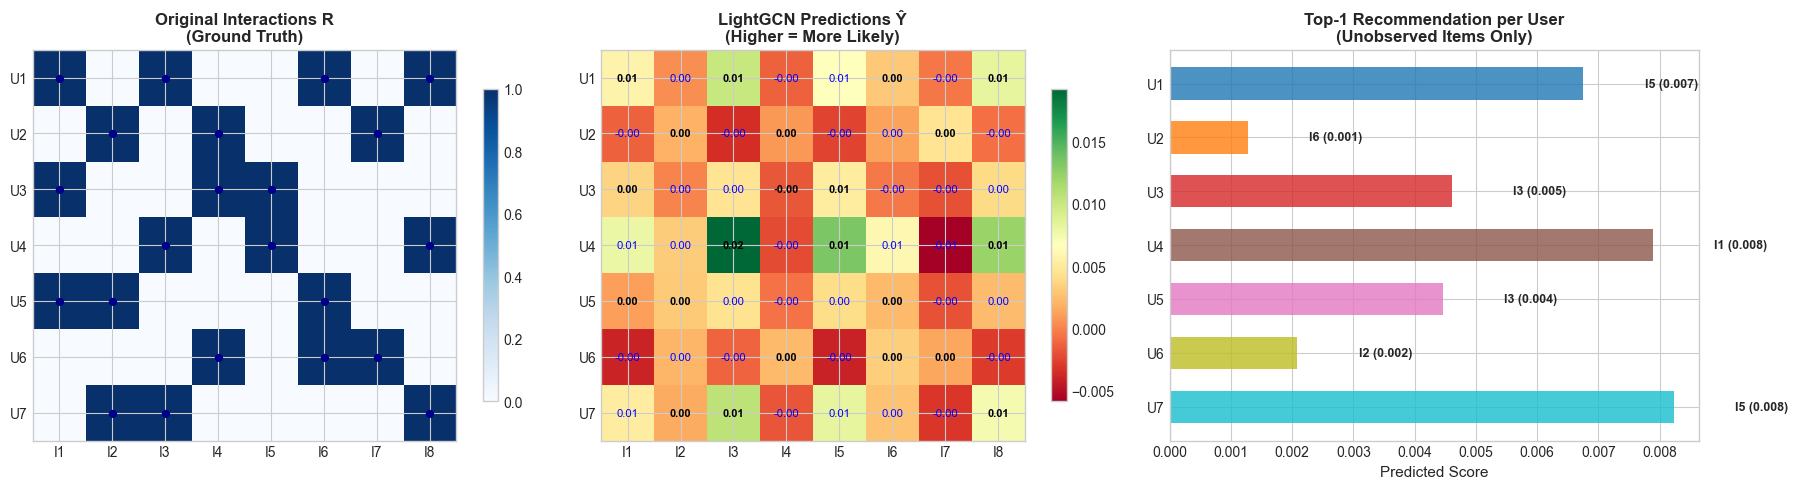


📋 Top-3 Recommendations for Each User:
------------------------------------------------------------
   U1: I5(0.007), I2(0.000), I7(-0.000)
   U2: I6(0.001), I8(-0.001), I1(-0.001)
   U3: I3(0.005), I8(0.004), I2(0.000)
   U4: I1(0.008), I6(0.006), I2(0.003)
   U5: I3(0.004), I5(0.004), I8(0.002)
   U6: I2(0.002), I3(-0.001), I8(-0.003)
   U7: I5(0.008), I1(0.005), I6(0.003)


In [14]:
# Visualize predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original interaction matrix
ax1 = axes[0]
im1 = ax1.imshow(R, cmap='Blues', aspect='auto', vmin=0, vmax=1)
ax1.set_xticks(range(N))
ax1.set_yticks(range(M))
ax1.set_xticklabels(items, fontsize=10)
ax1.set_yticklabels(users, fontsize=10)
ax1.set_title('Original Interactions R\n(Ground Truth)', fontsize=12, fontweight='bold')
for i in range(M):
    for j in range(N):
        text = '●' if R[i, j] == 1 else ''
        ax1.text(j, i, text, ha='center', va='center', fontsize=14, color='darkblue')
plt.colorbar(im1, ax=ax1, shrink=0.8)

# LightGCN predictions
ax2 = axes[1]
im2 = ax2.imshow(Y_hat, cmap='RdYlGn', aspect='auto')
ax2.set_xticks(range(N))
ax2.set_yticks(range(M))
ax2.set_xticklabels(items, fontsize=10)
ax2.set_yticklabels(users, fontsize=10)
ax2.set_title('LightGCN Predictions Ŷ\n(Higher = More Likely)', fontsize=12, fontweight='bold')
for i in range(M):
    for j in range(N):
        color = 'blue' if R[i, j] == 0 else 'black'
        weight = 'normal' if R[i, j] == 0 else 'bold'
        ax2.text(j, i, f'{Y_hat[i, j]:.2f}', ha='center', va='center', 
                fontsize=8, color=color, fontweight=weight)
plt.colorbar(im2, ax=ax2, shrink=0.8)

# Ranking: For each user, rank items by predicted score
ax3 = axes[2]
# Show top-3 recommendations for each user
recommendations = []
for u in range(M):
    # Get items not interacted with
    unobserved = np.where(R[u] == 0)[0]
    # Sort by predicted score
    scores = Y_hat[u, unobserved]
    top_indices = np.argsort(-scores)[:3]
    top_items = [items[unobserved[i]] for i in top_indices]
    top_scores = [scores[i] for i in top_indices]
    recommendations.append((users[u], top_items, top_scores))

# Create bar chart of top recommendations
y_pos = np.arange(M)
colors = plt.cm.tab10(np.linspace(0, 1, M))

for u in range(M):
    user, top_items, top_scores = recommendations[u]
    ax3.barh(y_pos[u], top_scores[0], color=colors[u], alpha=0.8, height=0.6)
    ax3.text(top_scores[0] + 0.001, y_pos[u], f'{top_items[0]} ({top_scores[0]:.3f})', 
             va='center', fontsize=9, fontweight='bold')

ax3.set_yticks(y_pos)
ax3.set_yticklabels(users, fontsize=10)
ax3.set_xlabel('Predicted Score', fontsize=11)
ax3.set_title('Top-1 Recommendation per User\n(Unobserved Items Only)', fontsize=12, fontweight='bold')
ax3.invert_yaxis()

plt.tight_layout()
plt.show()

print("\n📋 Top-3 Recommendations for Each User:")
print("-" * 60)
for user, top_items, top_scores in recommendations:
    items_str = ", ".join([f"{item}({score:.3f})" for item, score in zip(top_items, top_scores)])
    print(f"   {user}: {items_str}")

## 8. NGCF vs LightGCN: Comparison

Let's compare the two GNN architectures we've implemented:

| Aspect | NGCF | LightGCN |
|--------|------|----------|
| **Feature Transformation** | Linear (W₁, W₂) | None |
| **Activation Function** | LeakyReLU | None |
| **Interaction Term** | ✓ (e_u ⊙ e_i) | ✗ |
| **Layer Combination** | Concatenation | Weighted Sum |
| **Parameters** | O(K² × L) | O(K × (M+N)) only embeddings |
| **Complexity** | Higher | Lower |

### Why LightGCN Often Works Better:
1. **No Nonlinearity Needed**: In CF, we don't have rich node features—only IDs → nonlinearity can be redundant
2. **Simpler = More Generalizable**: Fewer parameters reduce overfitting risk
3. **Neighbor Averaging is Sufficient**: The graph structure provides enough signal

Comparison: User 1 (U1) Embeddings Evolution

🔷 NGCF Approach:
   Initial E_U1^(0): [ 0.0497 -0.0138  0.0648  0.1523]
   After Layer 1 E_U1^(1): Using W1, W2 matrices + LeakyReLU
   Final: Concatenate [E^(0); E^(1); E^(2); ...]

🔶 LightGCN Approach:
   Initial E_U1^(0):  [ 0.0497 -0.0138  0.0648  0.1523]
   After Layer 1:     [-0.0256 -0.1248 -0.0368  0.0762]
   After Layer 2:     [ 0.0008 -0.0302 -0.055   0.0018]
   After Layer 3:     [-0.0346 -0.109  -0.0193  0.0531]
   Final (averaged):  [-0.0024 -0.0695 -0.0116  0.0708]


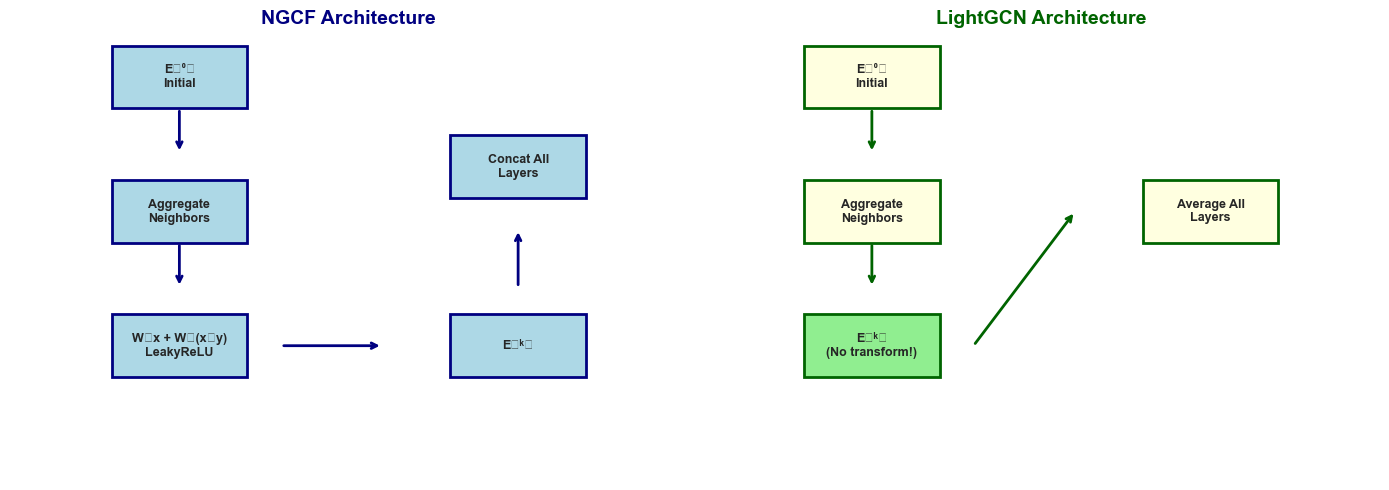


💡 Key Insight:
   LightGCN removes trainable weight matrices W₁, W₂ and nonlinear activation,
   relying purely on the graph structure for message passing.
   Despite its simplicity, it often outperforms NGCF in practice!


In [17]:
# Compare NGCF and LightGCN embeddings for User 1
print("=" * 70)
print("Comparison: User 1 (U1) Embeddings Evolution")
print("=" * 70)

# NGCF embeddings (use lightgcn.E0 which is the same initial embedding)
print("\n🔷 NGCF Approach:")
print(f"   Initial E_U1^(0): {lightgcn.E0[0].round(4)}")
print(f"   After Layer 1 E_U1^(1): Using W1, W2 matrices + LeakyReLU")
print(f"   Final: Concatenate [E^(0); E^(1); E^(2); ...]")

print("\n🔶 LightGCN Approach:")
print(f"   Initial E_U1^(0):  {E_layers_lgcn[0][0].round(4)}")
print(f"   After Layer 1:     {E_layers_lgcn[1][0].round(4)}")
print(f"   After Layer 2:     {E_layers_lgcn[2][0].round(4)}")
print(f"   After Layer 3:     {E_layers_lgcn[3][0].round(4)}")
print(f"   Final (averaged):  {E_final_lgcn[0].round(4)}")

# Visualize the difference in approach
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: NGCF architecture diagram
ax1 = axes[0]
ax1.set_xlim(-0.5, 3.5)
ax1.set_ylim(-0.5, 4.5)

# Draw boxes
boxes = [
    (0.5, 4, 'E⁽⁰⁾\nInitial'),
    (0.5, 2.5, 'Aggregate\nNeighbors'),
    (0.5, 1, 'W₁x + W₂(x⊙y)\nLeakyReLU'),
    (2.5, 1, 'E⁽ᵏ⁾'),
    (2.5, 3, 'Concat All\nLayers')
]

for x, y, text in boxes:
    rect = plt.Rectangle((x-0.4, y-0.35), 0.8, 0.7, fill=True, 
                         facecolor='lightblue', edgecolor='navy', linewidth=2)
    ax1.add_patch(rect)
    ax1.text(x, y, text, ha='center', va='center', fontsize=9, fontweight='bold')

# Arrows
ax1.annotate('', xy=(0.5, 3.15), xytext=(0.5, 3.65),
            arrowprops=dict(arrowstyle='->', color='navy', lw=2))
ax1.annotate('', xy=(0.5, 1.65), xytext=(0.5, 2.15),
            arrowprops=dict(arrowstyle='->', color='navy', lw=2))
ax1.annotate('', xy=(1.7, 1), xytext=(1.1, 1),
            arrowprops=dict(arrowstyle='->', color='navy', lw=2))
ax1.annotate('', xy=(2.5, 2.3), xytext=(2.5, 1.65),
            arrowprops=dict(arrowstyle='->', color='navy', lw=2))

ax1.set_title('NGCF Architecture', fontsize=14, fontweight='bold', color='navy')
ax1.axis('off')

# Right: LightGCN architecture diagram
ax2 = axes[1]
ax2.set_xlim(-0.5, 3.5)
ax2.set_ylim(-0.5, 4.5)

boxes2 = [
    (0.5, 4, 'E⁽⁰⁾\nInitial'),
    (0.5, 2.5, 'Aggregate\nNeighbors'),
    (0.5, 1, 'E⁽ᵏ⁾\n(No transform!)'),
    (2.5, 2.5, 'Average All\nLayers')
]

for x, y, text in boxes2:
    color = 'lightgreen' if 'No transform' in text else 'lightyellow'
    rect = plt.Rectangle((x-0.4, y-0.35), 0.8, 0.7, fill=True, 
                         facecolor=color, edgecolor='darkgreen', linewidth=2)
    ax2.add_patch(rect)
    ax2.text(x, y, text, ha='center', va='center', fontsize=9, fontweight='bold')

ax2.annotate('', xy=(0.5, 3.15), xytext=(0.5, 3.65),
            arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2))
ax2.annotate('', xy=(0.5, 1.65), xytext=(0.5, 2.15),
            arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2))
ax2.annotate('', xy=(1.7, 2.5), xytext=(1.1, 1),
            arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2))

ax2.set_title('LightGCN Architecture', fontsize=14, fontweight='bold', color='darkgreen')
ax2.axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("   LightGCN removes trainable weight matrices W₁, W₂ and nonlinear activation,")
print("   relying purely on the graph structure for message passing.")
print("   Despite its simplicity, it often outperforms NGCF in practice!")

## 9. Summary & Key Takeaways

### What We Learned:

1. **User-Item Bipartite Graph**: Collaborative filtering can be viewed as learning on a bipartite graph where edges represent interactions

2. **Graph Convolution for CF**: Message passing aggregates information from neighbors (items a user liked, users who liked an item)

3. **High-Order Connectivity**: Stacking GNN layers captures multi-hop relationships:
   - Layer 1: Direct neighbors
   - Layer 2: 2-hop neighbors (similar users/items)
   - Layer 3+: Higher-order collaborative signals

4. **NGCF**: Uses feature transformation + nonlinear activation + interaction terms
   - More expressive but more parameters to train

5. **LightGCN**: Pure linear propagation with layer averaging
   - Simpler but often more effective for collaborative filtering

### The Power of Graph Structure:

The key insight is that **neighborhood aggregation** naturally encodes collaborative signals:
- Users who interact with similar items will have similar embeddings
- Items interacted by similar users will have similar embeddings

This is achieved through the **normalized adjacency matrix multiplication**, which propagates and averages information across the graph structure.

Analysis: User Similarity from LightGCN Embeddings


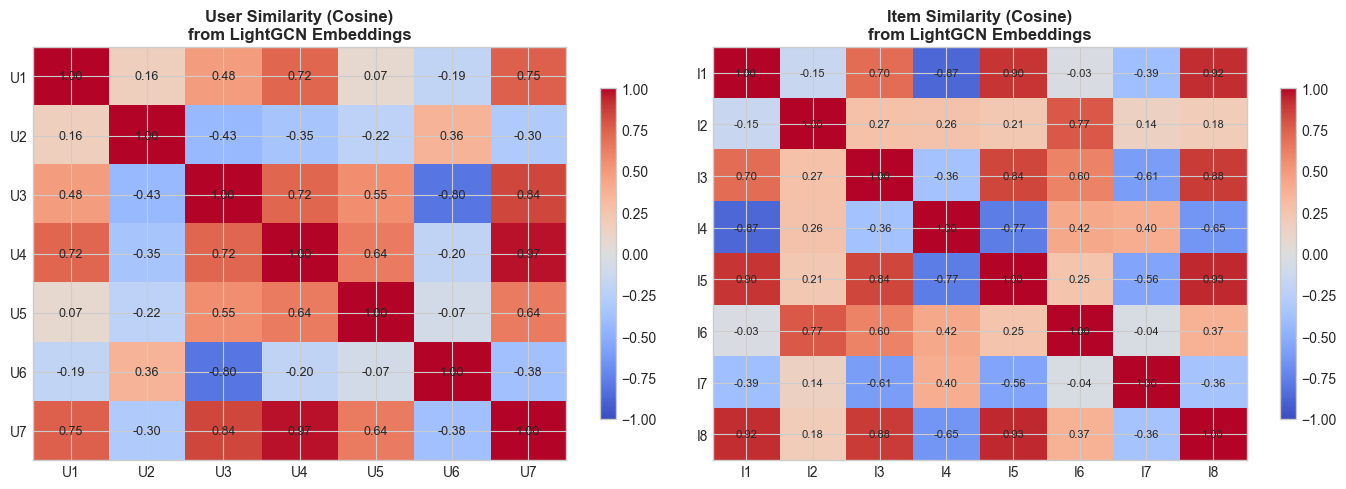


🔍 Most Similar User Pairs (excluding self):
   U4 ↔ U7: 0.9747
   U3 ↔ U7: 0.8397
   U1 ↔ U7: 0.7459

🔍 Most Similar Item Pairs (excluding self):
   I5 ↔ I8: 0.9317
   I1 ↔ I8: 0.9176
   I1 ↔ I5: 0.8983


In [18]:
# Final visualization: User similarity based on learned embeddings
print("=" * 70)
print("Analysis: User Similarity from LightGCN Embeddings")
print("=" * 70)

# Compute user similarity using final LightGCN embeddings
user_embeddings = E_final_lgcn[:M]  # First M rows are users
user_similarity = np.zeros((M, M))

for i in range(M):
    for j in range(M):
        # Cosine similarity
        dot_product = np.dot(user_embeddings[i], user_embeddings[j])
        norm_i = np.linalg.norm(user_embeddings[i])
        norm_j = np.linalg.norm(user_embeddings[j])
        user_similarity[i, j] = dot_product / (norm_i * norm_j + 1e-8)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User similarity heatmap
ax1 = axes[0]
im1 = ax1.imshow(user_similarity, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax1.set_xticks(range(M))
ax1.set_yticks(range(M))
ax1.set_xticklabels(users, fontsize=10)
ax1.set_yticklabels(users, fontsize=10)
ax1.set_title('User Similarity (Cosine)\nfrom LightGCN Embeddings', fontsize=12, fontweight='bold')
for i in range(M):
    for j in range(M):
        ax1.text(j, i, f'{user_similarity[i,j]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im1, ax=ax1, shrink=0.8)

# Item co-interaction analysis
ax2 = axes[1]
item_embeddings = E_final_lgcn[M:]  # Last N rows are items
item_similarity = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        dot_product = np.dot(item_embeddings[i], item_embeddings[j])
        norm_i = np.linalg.norm(item_embeddings[i])
        norm_j = np.linalg.norm(item_embeddings[j])
        item_similarity[i, j] = dot_product / (norm_i * norm_j + 1e-8)

im2 = ax2.imshow(item_similarity, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax2.set_xticks(range(N))
ax2.set_yticks(range(N))
ax2.set_xticklabels(items, fontsize=10)
ax2.set_yticklabels(items, fontsize=10)
ax2.set_title('Item Similarity (Cosine)\nfrom LightGCN Embeddings', fontsize=12, fontweight='bold')
for i in range(N):
    for j in range(N):
        ax2.text(j, i, f'{item_similarity[i,j]:.2f}', ha='center', va='center', fontsize=8)
plt.colorbar(im2, ax=ax2, shrink=0.8)

plt.tight_layout()
plt.show()

# Analyze most similar pairs
print("\n🔍 Most Similar User Pairs (excluding self):")
user_pairs = []
for i in range(M):
    for j in range(i+1, M):
        user_pairs.append((users[i], users[j], user_similarity[i, j]))
user_pairs.sort(key=lambda x: -x[2])
for u1, u2, sim in user_pairs[:3]:
    print(f"   {u1} ↔ {u2}: {sim:.4f}")

print("\n🔍 Most Similar Item Pairs (excluding self):")
item_pairs = []
for i in range(N):
    for j in range(i+1, N):
        item_pairs.append((items[i], items[j], item_similarity[i, j]))
item_pairs.sort(key=lambda x: -x[2])
for i1, i2, sim in item_pairs[:3]:
    print(f"   {i1} ↔ {i2}: {sim:.4f}")